## Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
import tqdm
import zipfile
import json
import cv2
import os
import re
from collections import defaultdict
import pickle

E:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Creating pretrained encoded images

Link for images and captions http://cocodataset.org/#download

In [2]:
IMAGE_PATH = "E:/Projects/Captioning/"

In [3]:
def inception_encoder():
    '''
    This function returns the cnn model to apply to each images as well as the preprocessing
    '''
    tf.keras.backend.set_learning_phase(False)
    preprocessing = tf.keras.applications.inception_v3.preprocess_input
    model = tf.keras.applications.InceptionV3(include_top=False) #I use inception
    model = tf.keras.models.Model(model.inputs, tf.keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocessing

In [4]:
def get_img_embeddings(filename,encoder,preprocessor):
    '''
    This function expects a zip filename, a cnn encoder and its preprocessor function from a pretrained keras model
    '''
    
    zf = zipfile.ZipFile(filename)
    num_images=len(zf.namelist())
    i=0
    imgs_batch = []
    imgs_embeddings = []
    filenames = []
    #Could be better by having a read thread (TODO) but takes only 17Min so its reasonable for now to use simple for loop
    for f in tqdm.tqdm_notebook(zf.namelist()):
        i+=1
        if os.path.splitext(f)[-1]=='.jpg':
            filenames.append(f.split('/')[-1])
            img = bytearray(zf.read(f)) #raw bytes
            img = cv2.imdecode(np.array(img),1) #this returns an image in BGR format
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Convert it to RGB (helps displays)

            #The inception model requires square images so we must first crop it to a centered square
            h,w,_ = img.shape
            if h > w:
                d = h - w #Need to crop the height
                img = img[d-d//2:h-d//2,:,:]
            else:
                d = w - h #Need to crop width
                img = img[:,d-d//2:w-d//2,:]

            #Need to be resized for inception
            img = cv2.resize(img, (299,299)).astype("float32")  # resize for our model
            img = preprocessor(img)  # preprocess for model (normalization)
            imgs_batch.append(img)
            
            if i%1024==0 or i==num_images:
                imgs_batch = np.stack(imgs_batch,axis=0)
                imgs_embeddings.append(encoder.predict(imgs_batch))
                imgs_batch=[]
    imgs_embeddings = np.vstack(imgs_embeddings)
    
    return imgs_embeddings, filenames

In [5]:
image_encoder,inception_preprocessing = inception_encoder()

In [6]:
filename = IMAGE_PATH+'train2017.zip'
train_imgs_embeddings, train_filenames =get_img_embeddings(filename,image_encoder,inception_preprocessing)
with open(IMAGE_PATH+'trainimgs.pkl', "wb") as f:
    pickle.dump(train_imgs_embeddings, f, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
train_imgs_embeddings.shape #Should be same length -1 as the tqdm counter

(118287, 2048)

In [8]:
filename = IMAGE_PATH+'val2017.zip'
val_imgs_embeddings, val_filenames =get_img_embeddings(filename,image_encoder,inception_preprocessing)
with open(IMAGE_PATH+'valimgs.pkl', "wb") as f:
    pickle.dump(val_imgs_embeddings, f, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
val_imgs_embeddings.shape

(5000, 2048)

## Load Captions

In [10]:
def get_captions(filenames,caption_path):
    
    id_to_captions = defaultdict(list)
    
    with open(caption_path,'br') as capfile:
        j = json.load(capfile)
        j_imgs = j['images']
        j_caps = j['annotations']
        fn_to_id = {i['file_name']:i['id'] for i in j_imgs}
        for c in j_caps:
            id_to_captions[c['image_id']].append(c['caption'].lower()) #lowercase
        captions = [id_to_captions[fn_to_id[fn]] for fn in filenames]
    
    return captions

In [11]:
caption_path = IMAGE_PATH+'captions_train2017.json'
train_captions = get_captions(train_filenames,caption_path)
caption_path = IMAGE_PATH+'captions_val2017.json'
val_captions = get_captions(val_filenames,caption_path)

E:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


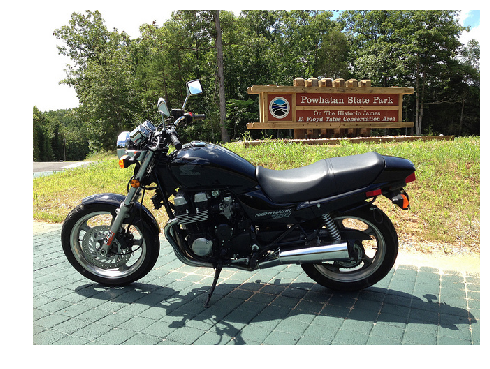

['motorcycle parked out on the path at the state park', 'a black and silver parked motorcycle a sign and trees', 'the motorcycle is next to a wood sign.', 'a motorcycle sitting on the pavement at powhatan state park.', 'a very sunny day at the state park for a motorcycle ride. ']


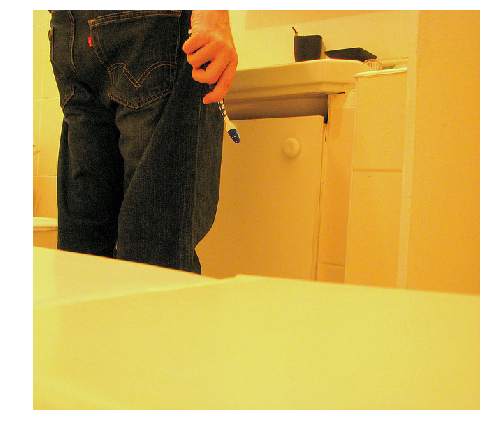

['a person wearing levi jeans is holding a toothbrush', 'a person holding a toothbrush in his hand.', 'a man holding a brush standing in a room', 'a person is holding a toothbrush in a bathroom. ', 'a man standing in front of a counter holding a tooth brush.']


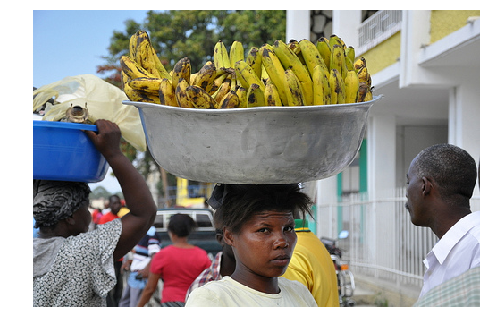

['a woman with a bowl of bananas on her head.', 'a woman stares at the camera with a basket of bananas on her head.', 'a woman with a bucket on her head filled with bananas. ', 'a woman walking around with a bushel of bananas on her head', 'a women on a busy street carrying a metal bowl full of ripe plantains on her head.']


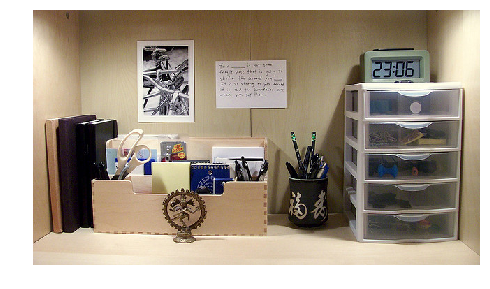

['a shelf with a written note on the wall, a small organization drawer set, various office supplies and a clock and photo on the wall.', 'a view of a corner of a desk with some items.', 'a shelf filled with a plastic storage unit and an alarm clock next to other office supplies.', 'a shelf containing books, stationery, and a clock.', 'the desk is organized with stationery, plastic drawers, pencils and a clock.']


In [12]:
#Let's check everything is in the right order
zf = zipfile.ZipFile(IMAGE_PATH+'train2017.zip')
i=0
for f in zf.namelist()[:5]:
    if os.path.splitext(f)[-1]=='.jpg':
        img = bytearray(zf.read(f)) #raw bytes
        img = cv2.imdecode(np.array(img),1) #this returns an image in BGR format
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Convert it to RGB (helps displays) 
        fig = plt.figure(figsize=(8, 8))
        plt.grid('off')
        plt.axis('off')
        plt.imshow(img)
        plt.show()
        print(train_captions[i])
        i+=1

## From captions to token matrix

In [13]:
def captions_to_id(vocab,captions):
    captions_ids = []
    for caps in captions:
        ids = [[vocab['START']]+[vocab.get(word,vocab['UNK']) for word in re.split('\W+', c) if len(word)>0]+[vocab['END']] for c in caps]
        captions_ids.append(ids)
    return captions_ids

In [14]:
def ids_to_matrix(ids,vocab):
    #Leverage a Keras function
    return pad_sequences(ids,value=vocab['PAD'],padding='post')

In [15]:
words = [word for caps in train_captions for c in caps for word in re.split('\W+', c) if len(word)>0]
counts = {}
for w in words:
    counts[w] = counts.get(w,0)+1
vocab = {}
vocab['PAD']=0
i=1
for k,c in counts.items():
    if c >= 5: #Discard rare words
        vocab[k]=i
        i+=1
vocab['START']=i
vocab['UNK']=i+1
vocab['END']=i+2

In [16]:
train_ids = captions_to_id(vocab,train_captions)
val_ids = captions_to_id(vocab,val_captions)

In [17]:
#During a batch we will have to pad the token ids to the maxlength of the batch
test = [train_ids[0][0],train_ids[1][1],train_ids[2][0]]
ids_to_matrix(test,vocab)

array([[10189,     1,     2,     3,     4,     5,     6,     7,     5,
            8,     9, 10191],
       [10189,    10,    27,    30,    10,    31,    32,    33,    34,
        10191,     0,     0],
       [10189,    10,    44,    45,    10,    46,    41,    47,     4,
           48,    49, 10191]])

## Building Model

In [18]:
tf.reset_default_graph()
tf.set_random_seed(32)
sess = tf.InteractiveSession()

#Image encodding input
img_encoding = tf.placeholder('float32',[None,2048]) #Image encoding size is 2048
#caption input/output (since the model is generative caption are both an input and an output)
captions = tf.placeholder('int32',[None,None])

image_to_lstm = tf.keras.layers.Dense(300,input_shape=(None,2048),activation='elu')

h0 = image_to_lstm(img_encoding) #Use 300 units LSTM. Therefore initial state is 300 size vector
c0 = h0 #Memory and hidden initial states at same value

#Caption as input (all but the END token)
embed_layer = tf.keras.layers.Embedding(len(vocab),150)
caption_embedding = embed_layer(captions[:,:-1]) #Often the gain between 200 and 300 is small

#Pass the embeddings in a LSTM
#dynamic rnn builds a RNN layer We initiate the LSTM with the img encodings
#Note: We will have to use it differently for predict. Here we have all the words as inputs to predict the next word at each step
lstm_cell = tf.nn.rnn_cell.LSTMCell(300)
h, _ = tf.nn.dynamic_rnn(lstm_cell,caption_embedding,initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0,h0))

#The output of RNN is [batch, time, rnn_size]
#The logloss however will be calculated across all words of the caption for the batch so we need to unroll the LSTM output
h_flat = tf.reshape(h,(-1,300)) 
y = tf.reshape(captions[:,1:],[-1]) #same for what we need to predict (everything but the START token)

#Predict word logit
lstm_to_logits =  tf.keras.layers.Dense(len(vocab),input_shape=(None,300))
word_logits = lstm_to_logits(h_flat)

#Padding mask (no crossentropy there)
pad_mask = tf.not_equal(y,tf.constant(vocab['PAD']))
cross_ent = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=word_logits) #sparse_softmax puts a softmax directly
cross_ent_masked = tf.boolean_mask(cross_ent,pad_mask)
loss = tf.reduce_mean(cross_ent_masked,axis=0)

In [19]:
optimizer = tf.train.AdamOptimizer()
update_step = optimizer.minimize(loss)
sess.run(tf.global_variables_initializer())
save = tf.train.Saver()

E:\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Train the model

In [20]:
def batch_generator(img_encods, captions_id, vocab, batch_size=32):
    """
    This function returns a sample batch to train the model on.
    """
    #Note that the sampling is 100% random. A better way could be to use a generator yield
    
    #Sample the examples:
    ids = np.random.choice(img_encods.shape[0],batch_size)
    batch_img_encods = img_encods[ids,:]

    #Sample the caption for the exact same samples
    ids_c = np.random.choice(5,batch_size)
    batch_caps = [captions_id[i][j] for i,j in zip(ids,ids_c)]
    batch_caps = ids_to_matrix(batch_caps,vocab)
    
    return batch_img_encods, batch_caps

In [28]:
np.random.seed(32)
batch_size = 64
N = train_imgs_embeddings.shape[0]//batch_size
N_VAL = 200

for epoch in range(9):
    
    train_loss = 0
    tqdm_bar = tqdm.tqdm_notebook(range(N))
    for i in tqdm_bar: #Note that since batch is random its not really a batch size
        img_batch, cap_batch = batch_generator(train_imgs_embeddings, train_ids,vocab,batch_size)
        train_loss += sess.run([loss,update_step],feed_dict={img_encoding:img_batch,captions:cap_batch})[0]
        tqdm_bar.set_description("Train: %f" % (train_loss / i))
        
    train_loss /= N
    
    val_loss = 0
    for _ in range(N_VAL):
        img_batch, cap_batch = batch_generator(val_imgs_embeddings, val_ids,vocab,batch_size)
        val_loss += sess.run(loss,feed_dict={img_encoding:img_batch,captions:cap_batch})
          
    val_loss /= N_VAL
    
    print('Train: {}, Val: {}'.format(train_loss, val_loss))

save.save(sess,IMAGE_PATH+'weigths')

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]



Train: 2.49282186475151, Val: 2.5921464228630064



Train: 2.4495454237058567, Val: 2.544925620555878



Train: 2.409191399941713, Val: 2.5521294808387758


'E:/Projects/Captioning/weigths'

## Predictor model

In [29]:
id_to_word = {i:k for k,i in vocab.items()}

In [30]:
def process_image(image_raw,preprocessor):
    
    '''
    Picks the raw data from an image file and format it for the model
    '''
    
    img = bytearray(image_raw) #raw bytes
    img = cv2.imdecode(np.array(img),1) #this returns an image in BGR format
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Convert it to RGB (helps displays)

    #The inception model requires square images so we must first crop it to a centered square
    h,w,_ = img.shape
    if h > w:
        d = h - w #Need to crop the height
        img = img[d-d//2:h-d//2,:,:]
    else:
        d = w - h #Need to crop width
        img = img[:,d-d//2:w-d//2,:]

    fig = plt.figure(figsize=(8, 8))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    #Need to be resized for inception
    img = cv2.resize(img, (299,299)).astype("float32")  # resize for our model
    img = preprocessor(img)  # preprocess for model (normalization)
    
    return img

In [31]:
def predict(img, vocab,id_to_word,maxlen=50):
    
    sess.run(lstm_states,{img_input: img})
    
    generated = [vocab['START']] #First word
    
    for i in range(maxlen):
        
        probs = sess.run(step,{word:[generated[-1]]})[0] #only interested in probability
        probs = probs.reshape(-1)

        new_word = np.argmax(probs)
        generated.append(new_word)
        
        if new_word == vocab['END']:
            break
       
    return list(map(id_to_word.get, generated))

In [32]:
#The predictor has a different architecture. 

#First the image encoder is now part of the model rather than a direct pretrain
image_encoder,inception_preprocessing = inception_encoder()

img_input = tf.placeholder('float32', [1, 299, 299, 3])
img_encodings = image_encoder(img_input)

#Restore weights
save.restore(sess,IMAGE_PATH+'weigths')  #Apparently Keras breaks stuff :X 
h = tf.Variable(tf.zeros([1, 300]), name="hidden")
c = tf.Variable(tf.zeros([1, 300]), name="memory")
h0 = image_to_lstm(img_encodings)
c0 = h0

lstm_states = tf.assign(c,c0),tf.assign(h,h0)

#Main 
word = tf.placeholder('int32',[1],name='word')
word_embed = embed_layer(word)
new_c,new_h = lstm_cell(word_embed,tf.nn.rnn_cell.LSTMStateTuple(c,h))[1] #[1] to get the states tuple
logits = lstm_to_logits(new_h)
probs = tf.nn.softmax(logits)
step = probs, tf.assign(c,new_c), tf.assign(h,new_h) #When calling a run on step it will run the main part each time

INFO:tensorflow:Restoring parameters from E:/Projects/Captioning/weigths


In [33]:
zf = zipfile.ZipFile(IMAGE_PATH+'val2017.zip')
val_ln = zf.namelist()

E:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


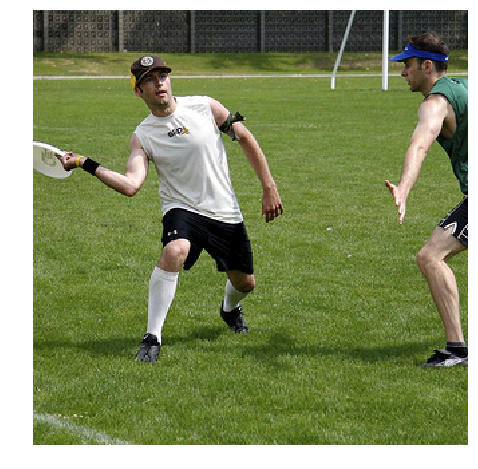

Predicted Caption: a man in a field playing with a frisbee


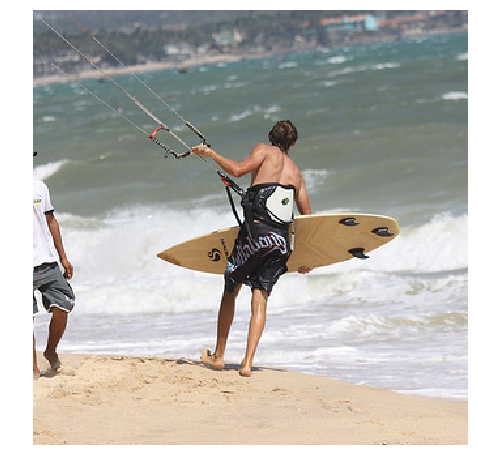

Predicted Caption: a man is on a beach with a surfboard


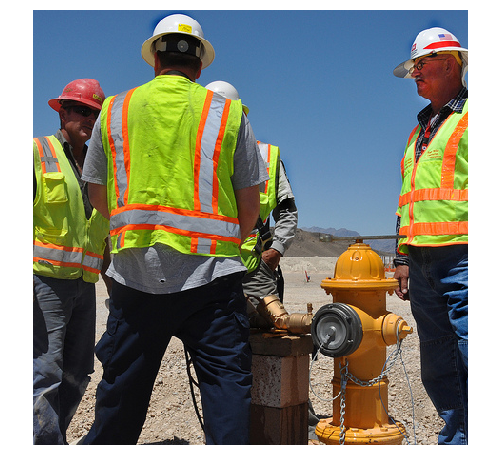

Predicted Caption: a man and a boy on a skateboard


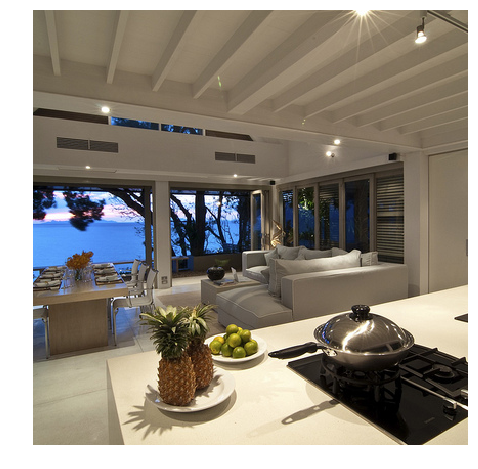

Predicted Caption: a living room with a table and a table


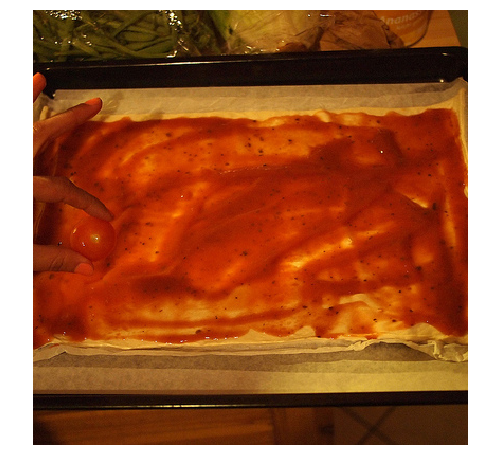

Predicted Caption: a pizza with cheese and cheese on a plate


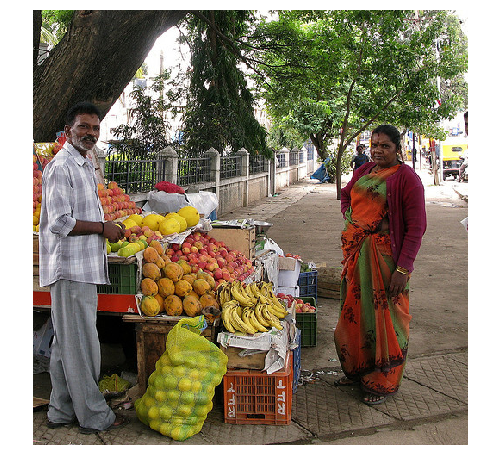

Predicted Caption: a man and woman are standing in front of a market


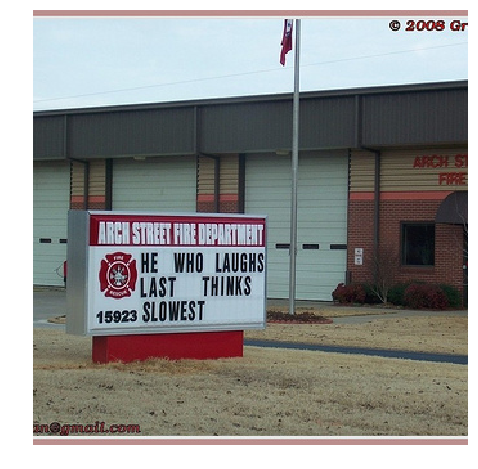

Predicted Caption: a stop sign with a sign on it


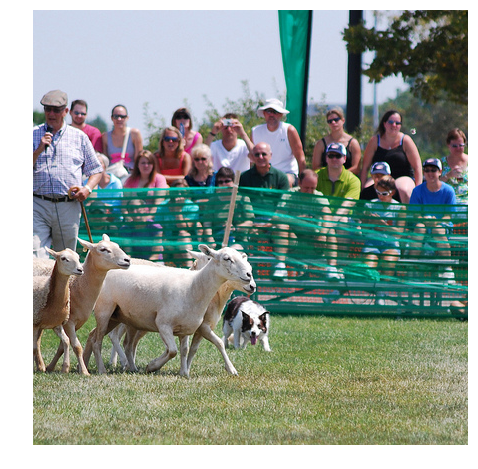

Predicted Caption: a dog is standing in the grass with a frisbee


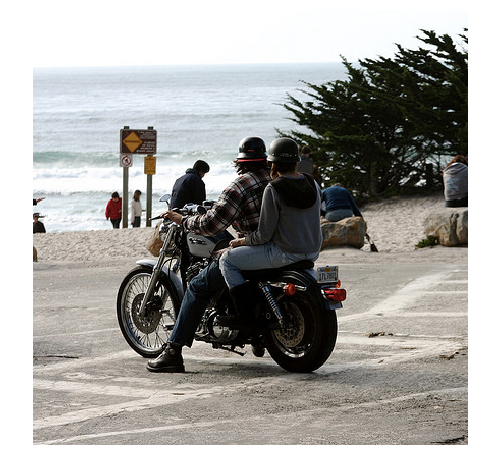

Predicted Caption: a man riding a motorcycle on a city street


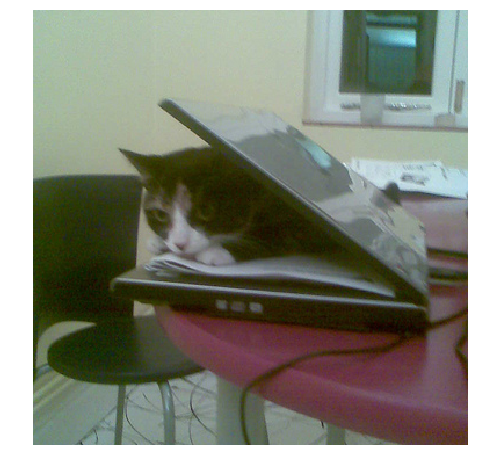

Predicted Caption: a woman sitting on a couch using a laptop


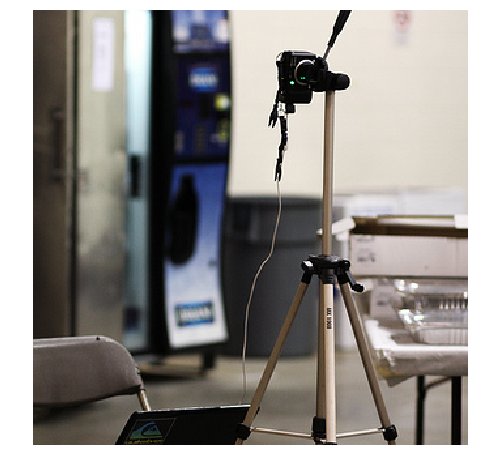

Predicted Caption: a close up of a person holding a cell phone


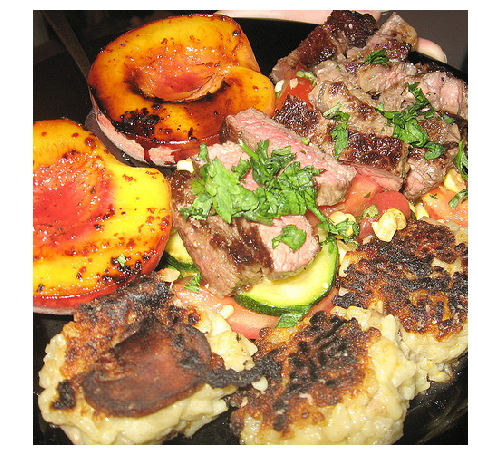

Predicted Caption: a pizza with cheese and cheese on a plate


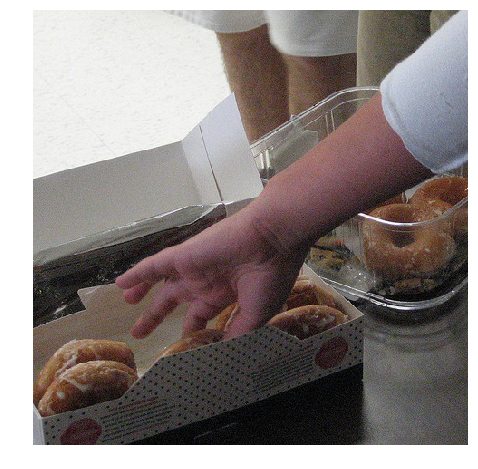

Predicted Caption: a man holding a donut in a box


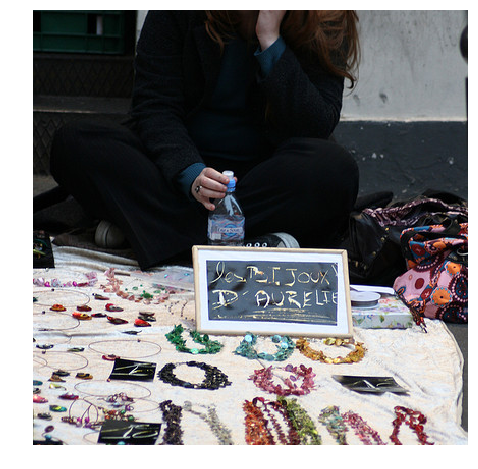

Predicted Caption: a man sitting on a chair with a laptop


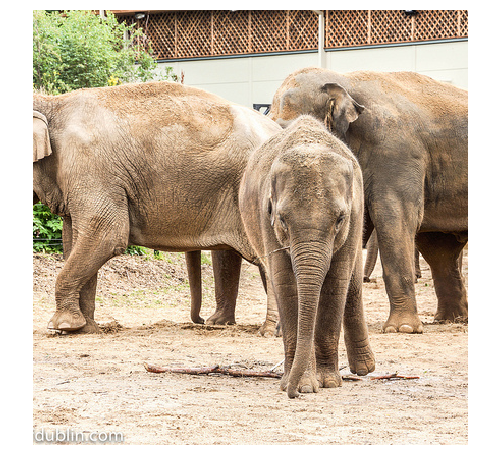

Predicted Caption: a group of elephants standing around a fence


In [34]:
sample = np.random.randint(1,len(val_ln),15)
for i in sample:
    img = zf.read(val_ln[i])
    img = process_image(img,inception_preprocessing)
    print('Predicted Caption:',' '.join(predict([img],vocab,id_to_word)[1:-1]))